In [1]:
# Various Imports

# Data science
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Dim reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
import umap

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

# TDA
from ripser import Rips
from persim import PersImage
from persim import PersistenceImager

import warnings
warnings.filterwarnings('ignore')

# Load data

* relevant columns
    * `Imaging phenotype (cell type)`: ID of cell type. See dataframe `df_mmc` f or what each ID means
    * `X.X`: x-coordinate of cell
    * `Y.Y`: y-coordinate of cell
    * `sample_Xtile_Ytile`: type of sample (BALB for normal, MRL for diseased) and tile numbers

In [2]:
df_cells = pd.read_csv('mouse_spleen_data/MRLdatasetexpression.csv', index_col = None)
df_mmc = pd.read_excel("mouse_spleen_data/mmc2.xlsx")

In [3]:
df_cells.head()

,Imaging phenotype cluster ID,CD45,Ly6C,TCR,Ly6G,CD19,CD169,CD106,CD3,CD1632,...,CD44,NKp46,X.X,Y.Y,Z.Z,MHCII,blank_Cy3_cyc15,blank_Cy5_cyc15,sample_Xtile_Ytile,niche cluster ID
0,9600,1577.675415,-154.301758,130.692184,-4.168493,560.691345,-504.231476,854.670105,-631.294189,385.935242,...,422.408691,515.130066,10,70,13,6712.812988,1665.967896,398.348389,BALBc-3_X05_Y03,32.0
1,9600,1017.838440,-93.069397,144.076584,40.010998,885.595520,-391.357544,62.764454,-474.201172,-469.634583,...,448.701660,171.880310,1000,294,12,2024.678711,1287.959229,421.991425,BALBc-3_X01_Y02,99.0
2,9600,5978.459961,-330.099365,139.631744,-82.840302,1747.897583,-395.508820,954.326782,-1026.204468,3744.718262,...,2229.804443,512.220764,1003,107,8,8647.193359,2817.173828,709.545105,BALBc-2_X05_Y04,74.0
3,9600,6119.109375,-54.384808,-768.871704,25.625927,1065.311890,-485.535431,538.404175,-611.836426,865.842590,...,665.720459,351.108246,1003,113,13,4838.463379,1646.660278,408.523590,BALBc-2_X03_Y04,98.0
4,9600,6272.474609,-235.512405,74.058075,-101.729919,1186.295044,-782.744995,1261.625366,-915.565552,1361.536011,...,2065.742676,259.003235,1003,148,9,5092.891602,2161.109131,713.416199,BALBc-2_X02_Y01,71.0


In [4]:
df_mmc.head()

,X-shift cluster ID,Imaging phenotype (cell type)
0,9626,plasma cells
1,9593,plasma cells
2,9641,noid
3,9644,noid
4,9605,noid


# Computation of the persistence diagrams

First we try to compute persistence diagrams for stiched tiles. It seems to be computationaly expensive but it seems faisable with a slightly better ram than mine. So we stick to tiled data.

In [5]:
# Usefull cell types / Sample names

# Each cell types (remove useless cell type)
IDs = df_mmc[(df_mmc["Imaging phenotype (cell type)"] != "dirt") & (df_mmc["Imaging phenotype (cell type)"] != "noid") & (df_mmc["Imaging phenotype (cell type)"] != "capsule")]["X-shift cluster ID"].values
print(IDs)
# IDs reduction to have manageable computation
# IDs = IDs[0:18]

# Each sample names. MRL are sample from auto-immune disease. BALB are sample from wildtype
indices = df_cells.sample_Xtile_Ytile.value_counts().index.tolist()
SNs = list(set([item.split("_")[0] for item in indices]))
print(SNs)
# SNs reduction to have manageable computation
# SNs = ['BALBc-3']

[9626 9593 9615 9602 9604 9620 9609 9589 9613 9618 9607 9628 9592 9587
 9597 9596 9595 9638 9611 9637 9643 9619 9632 9629 9590 9635 9639 9608
 9617 9614 9591 9600 9606 9640]
['MRL-8', 'MRL-9', 'MRL-7', 'BALBc-3', 'BALBc-2', 'MRL-4', 'MRL-6', 'MRL-5', 'BALBc-1']


We compute for not stiched tiles. Even if it seems we might miss some "holes", it is reasonable to think that the information that are interesting are at a very tiny level. 

In [6]:
# To Compute Persistence Diagram
rips = Rips(maxdim=1)

# To store persistence diagram
diagrams = {}

index = 1
for SN in SNs: # each sample
    for ID in IDs: # each cell type
        # get (x,y) coordinates
        cells = df_cells[(df_cells["Imaging phenotype cluster ID"] == ID) & (df_cells["sample_Xtile_Ytile"].str.split(pat="_").str[0] == SN)]
        for i in range(1, 8):
            for j in range(1, 10):
                # xy_cells = df_cells[(df_cells["sample_Xtile_Ytile"].str.split(pat="_").str[0] == SN) & (df_cells["Imaging phenotype cluster ID"] == ID) & (df_cells["sample_Xtile_Ytile"].str.split(pat="_").str[1] == "X0"+str(i)) & (df_cells["sample_Xtile_Ytile"].str.split(pat="_").str[2] == "Y0"+str(j))]
                xy_cells = cells[(cells["sample_Xtile_Ytile"].str.split(pat="_").str[1] == "X0"+str(i)) & (cells["sample_Xtile_Ytile"].str.split(pat="_").str[2] == "Y0"+str(j))]
                if (not xy_cells.empty):
                    # Computation of Persistence Diagram (For each sample and each cell type)
                    data = np.array((xy_cells["X.X"].values,xy_cells["Y.Y"].values)).T
                    diagram = rips.fit_transform(data)
                    diagrams[(SN, ID, i, j)] = diagram
                else:
                    diagrams[(SN, ID, i, j)] = None


Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)



## Comparaison of data visualisation and persistence diagram
We can see that in many cases in don't have many structure in our data so the persistence diagram doesn't seems to reveal much but we can notice for example this sample in each we can see a structure which is detected in the persistence diagram since we have a few point of high persistence

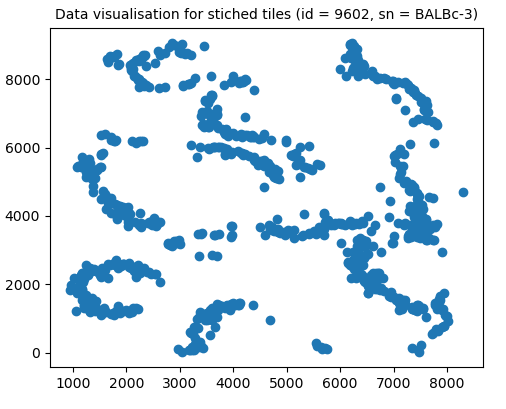 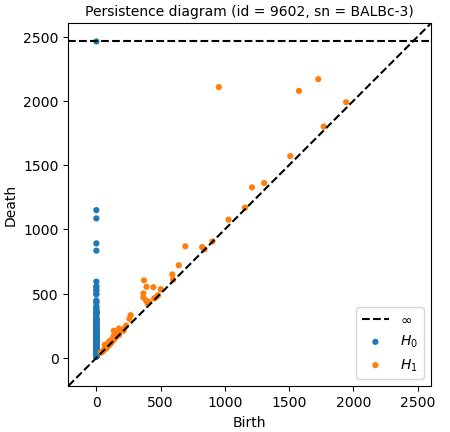

# Computing persistence images

In [7]:
pimgr = PersistenceImager(pixel_size=5)
pimgr.kernel_params = {'sigma': 5000.0}

In [8]:
# Attempt to fit all the images to the same size. I dont know if it's important that all images have the same images. Too computationnaly heavy

diagrams_array = list(diagrams.values())
diagrams_array = [diagram for diagram in diagrams_array if (diagram is not None)]
diagrams_h1_array = [diagram[1] for diagram in diagrams_array if (np.any(diagram[1]))]
pimgr.fit(diagrams_h1_array)

In [9]:
# Computing persistence images

images = {}

for SN in SNs: # each sample
    for ID in IDs: 
        for i in range(1, 8):
                for j in range(1, 10):
                    if diagrams[(SN, ID, i, j)] == None:
                        images[(SN, ID, i, j)] = None
                    else:
                        diagram = diagrams[(SN, ID, i, j)]
                        diagram_h1 = diagram[1]
                        if np.any(diagram_h1):
                            # pimgr.fit(diagram_h1)
                            image = pimgr.transform(diagram_h1, skew=True)
                            images[(SN, ID, i, j)] = image
                        else:
                            images[(SN, ID, i, j)] = None


# Ploting persistence images/diagram/data

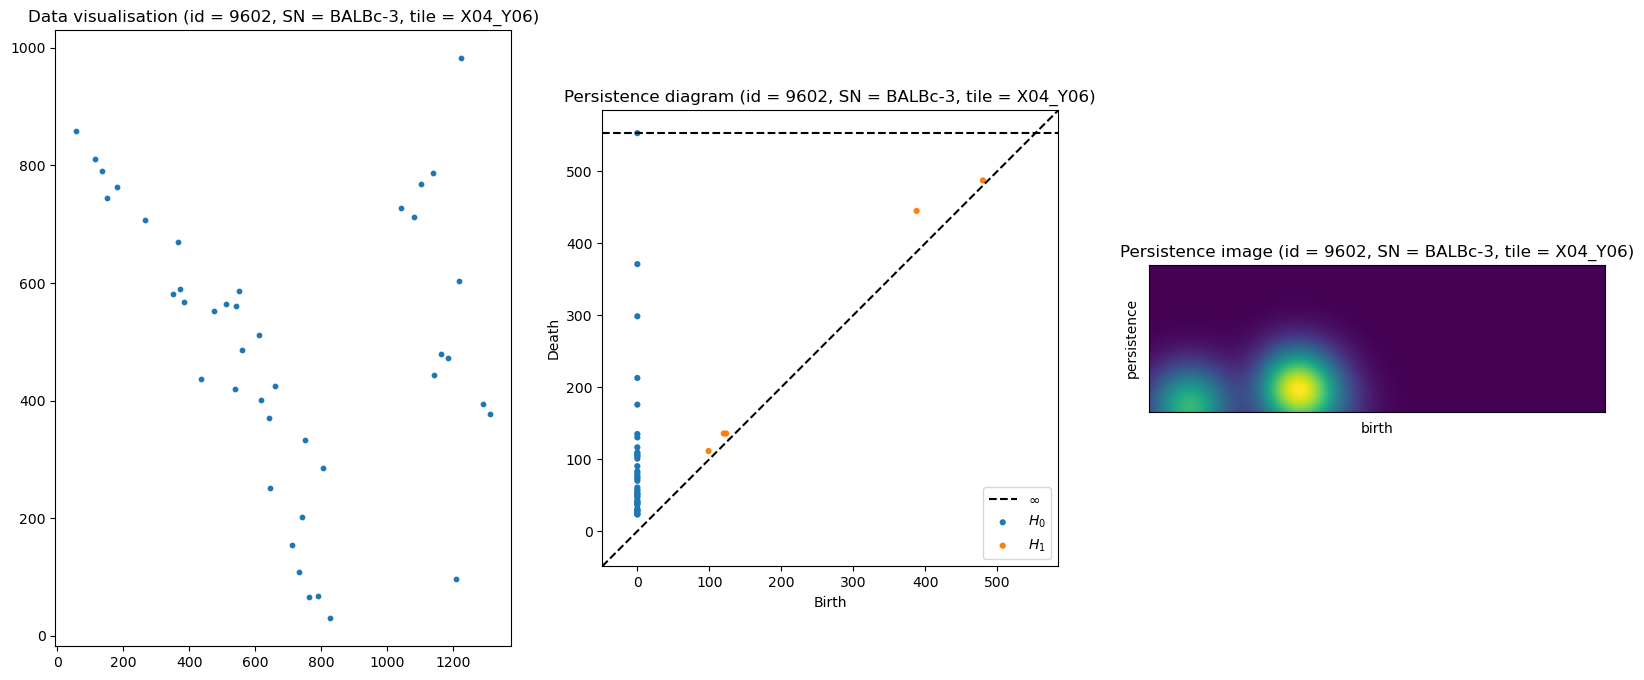

In [10]:
# Ploting persistence images/diagram/data
fig, axs = plt.subplots(1, 3, figsize=(20,8))

(SN, ID, i, j) = ('BALBc-3', 9602, 4, 6) 

# Data
xy_cells = df_cells[(df_cells["sample_Xtile_Ytile"].str.split(pat="_").str[0] == SN) & (df_cells["Imaging phenotype cluster ID"] == ID) & (df_cells["sample_Xtile_Ytile"].str.split(pat="_").str[1] == "X0"+str(i)) & (df_cells["sample_Xtile_Ytile"].str.split(pat="_").str[2] == "Y0"+str(j))]
axs[0].scatter(xy_cells["X.X"].values, xy_cells["Y.Y"].values, s=10)
axs[0].set_title(f"Data visualisation (id = {ID}, SN = {SN}, tile = X0{i}_Y0{j})")

# Diagram
diagram = diagrams[(SN, ID, i, j)]
if diagram == None:
    print("Empty diagram")
else:
    rips.plot(diagram, ax=axs[1])
    axs[1].set_title(f"Persistence diagram (id = {ID}, SN = {SN}, tile = X0{i}_Y0{j})")

# Image
image = images[(SN, ID, i, j)]
if image is None or not np.any(image):
    print("Empty image")
else:
    pimgr.plot_image(image, ax=axs[2])
    axs[2].set_title(f"Persistence image (id = {ID}, SN = {SN}, tile = X0{i}_Y0{j})")


# Show
plt.show()

# Trying classification

In [11]:
# We build our test/train data set

# SNs is ['MRL-6', 'BALBc-1', 'MRL-8', 'MRL-4', 'MRL-5', 'BALBc-3', 'MRL-9', 'BALBc-2', 'MRL-7']
SNs_MRL = ['MRL-6', 'MRL-8', 'MRL-4', 'MRL-5', 'MRL-9', 'MRL-7']
# SNs_BALBc = ['BALBc-1', 'BALBc-2', 'BALBc-3']

images_mrl = []
images_balbc = []

for SN in SNs:
    for ID in IDs:
        for i in range(1, 8):
            for j in range(1, 10):
                if images[(SN, ID, i, j)] is not None and np.any(images[(SN, ID, i, j)]):
                    if SN in SNs_MRL:
                        images_mrl.append(images[(SN, ID, i, j)])
                    else:
                        images_balbc.append(images[(SN, ID, i, j)])



# Define labels (0 normal spleen, 1 disease)
labels = np.zeros(len(images_balbc) + len(images_mrl))
labels[len(images_mrl):] = 1    
images_array = np.array([image.flatten() for image in images_balbc] + [image.flatten() for image in images_mrl])

X_train, X_test, y_train, y_test = train_test_split(images_array, labels, test_size=0.40, random_state=42)

In [12]:
print(len([image.flatten() for image in images_balbc]))
print(len([image.flatten() for image in images_mrl]))
print(images_array.size)

1854
4338
104929632


In [13]:
# Try classification 

lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.702462656439241

<AxesSubplot: xlabel='birth', ylabel='persistence'>

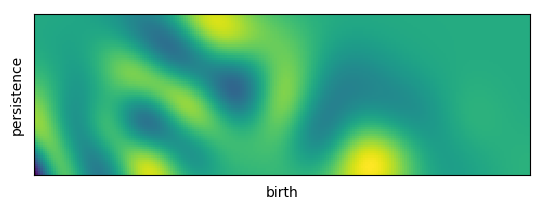

In [14]:
inverse_image = np.copy(lr.coef_).reshape(pimgr.resolution)
pimgr.plot_image(inverse_image)

# Dimensionality reduction

Here we try various dimensionality reduction technique. First linear and then non-linear (tsne, mds, umapm et check auto encoder variationel).


## Linear dimensionality reduction

tried pca but non linear might work better

In [15]:
# Linear dimensionality reduction

pca = PCA(n_components=2)
images_array_pca = (pca.fit_transform(images_array)).T

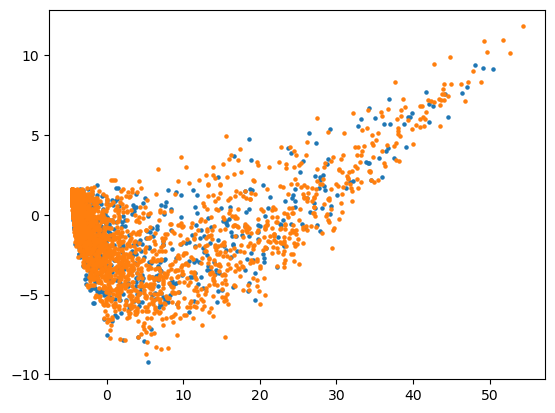

In [16]:
plt.scatter(images_array_pca[0][len(images_mrl):], images_array_pca[1][len(images_mrl):], s = 5)
plt.scatter(images_array_pca[0][:len(images_mrl)], images_array_pca[1][:len(images_mrl)], s = 5)
plt.show()

## Non Linear dimensionality reduction

- tsne
- mds
- umap
- variational auto-encoder

In [17]:
## Non-Linear dimensionality reduction

# TNSE
images_array_tnse = (TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(images_array)).T


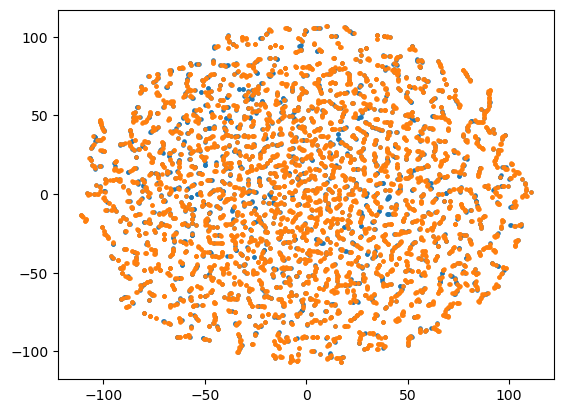

In [18]:
plt.scatter(images_array_tnse[0][len(images_mrl):], images_array_tnse[1][len(images_mrl):], s = 5)
plt.scatter(images_array_tnse[0][:len(images_mrl)], images_array_tnse[1][:len(images_mrl)], s = 5)
plt.show()

In [19]:
## Non-Linear dimensionality reduction

# MDS

nb = 800

mds = MDS(n_components=2)
images_array_mds = (mds.fit_transform(np.concatenate((images_array[0:nb], images_array[len(images_mrl):(len(images_mrl) + nb)]), axis=0))).T


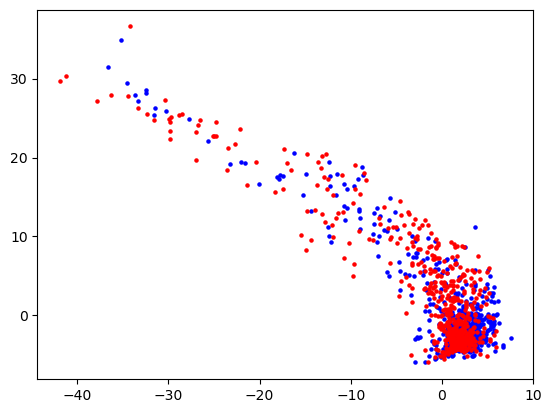

In [20]:
plt.scatter(images_array_mds[0][nb:], images_array_mds[1][nb:], s = 5)
plt.scatter(images_array_mds[0][:nb], images_array_mds[1][:nb], s = 5)
plt.show()

In [25]:
## Non-Linear dimensionality reduction

# UMAP

nb = 300

reducer = umap.UMAP()
images_array_umap = (reducer.fit_transform(np.concatenate((images_array[0:nb], images_array[len(images_mrl):(len(images_mrl) + nb)]), axis=0))).T

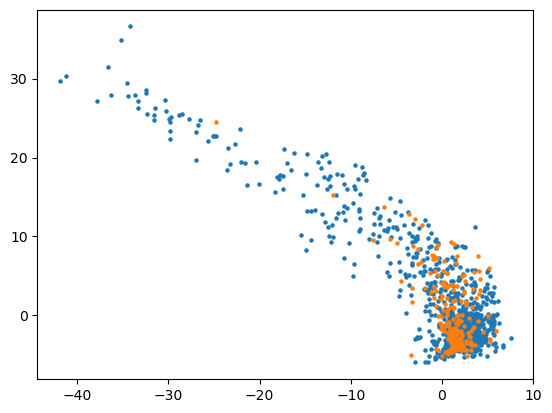

In [27]:
plt.scatter(images_array_mds[0][nb:], images_array_mds[1][nb:], s = 5)
plt.scatter(images_array_mds[0][:nb], images_array_mds[1][:nb], s = 5)
plt.show()